In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import cvxpy as cvx
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
def rebalance(h, r_hat, costs, SIGMA, RISK_AVERSION):
    '''
    An auxiliary function that performs the formulation of the optimization problem
    in the CVXPY.
    
    Input: h - current portfolio
          r_hat - predicted returns
          costs - transaction costs
          SIGMA - covariance matrix of the returns
          RISK_AVERSION - risk aversion parameter
          
    Output: u - solution
            prob.value - the value of the objective function at the solution point
    '''
    u = cvx.Variable(len(pred_returns.columns))
    RISK = cvx.quad_form(h+u, SIGMA)
    obj = cvx.Maximize(r_hat@h + r_hat@u - costs@u - RISK_AVERSION*RISK)
    constr = [h+u >= 0, sum(u)+costs@u == 0]
    prob = cvx.Problem(obj, constr)
    prob.solve( solver='SCS')
    
    return u.value, prob.value

def compressor(u, op_pr, h, r_true, nan_sign, bad_positions):
    '''
    The function rounds the vector of operations u, focusing on current prices.
    '''
    for i in range(len(u)):
        if (i == len(u)-1) or (u[i] == 0): #Если алг. не предлагает действий или мы на банке - то пасс
            continue
        if i in bad_positions:            #Если наш актив плохо предсказывается(низкая точность), то не работаем с ним
            u[-1] += u[i]
            u[i] = -h[i]
            u[-1] -= u[i]
        if r_true[i] == nan_sign: #Если не сможем посчитать доходность по активу в конце перода,то сливаем полностью
            u[-1] += u[i]
            u[i] = -h[i]                   #Продаём то что было в прортфеле до этого 
            u[-1] -= u[i]                 #Продаём то что было в прортфеле до этого 
        elif op_pr[i] == nan_sign:       #Если не знаем закупочную цену
            if u[i] > 0:                #Если хотели покупать, то не покупаем
                u[-1] += u[i]
                u[i] = 0
            else:              #Если хотели продавать(т.к он упадёт) то сливаем его как можно быстрее по любой цене
                u[-1] += u[i]
                u[i] = -h[i]
                u[-1] -= u[i] 
        else:                       
            operation = np.sign(u[i])
            
            res = abs(u[i]) - op_pr[i]*( abs(u[i]) //op_pr[i]) #Остаток от возможной операции
            
            u[i] = operation*( op_pr[i]*( abs(u[i]) //op_pr[i]) ) #Совершаем доступную операцию
            
            u[-1] += operation*(res) #Остаток скидываем в кэш + учитываем комиссию за u[i]
    return u

def toler1(u, tol):
    '''
    The function zeroes all coordinates(removing noise).
    '''
    for i in range(len(u)):
        if i == len(u)-1:
            continue
        elif abs(u[i]) < tol:
            u[-1] += u[i]
            u[i] = 0
    return u

def toler2(h_star, open_prices, r_true, nan_sign):
    '''
    The function zeroes all coordinates(removing noise).
    '''
    for i in range(len(h_star)):
        if i == len(h_star)-1:
            continue
        elif r_true[i] == nan_sign:
            h_star[-1] += h_star[i]
            h_star[i] = 0
        
    return h_star

def costing(h_star, cost):
    '''
    Transaction costs function 
    '''
    for i in range(len(h_star)):
        if i == len(h_star)-1 or h_star[i] == 0: #Если мы на банке или же не торгуем, то continue
            continue
        else:
            h_star[-1] -= cost*abs(h_star[i])
            
    return h_star

def oneiter(pred_returns,
             fact_returns,
             opens,
             nan_sign,
             cash_account,
             tol,
             cost,
             risk_aversion,
             period ):
    '''
    An auxiliary function that makes only one iteration(you must choose exact trading period).
    It outputs the solution u_star.
    '''
#==============ПОДГОТОВКА К НАЧАЛУ ТЕСТА======================    
    #-----Составление ковариационной матрицы доходностей SIGMA-----
    returns_for_cov = fact_returns.copy()
    for i in list(returns_for_cov.columns):
        returns_for_cov[i] = returns_for_cov[i].fillna(returns_for_cov[i].mean())
    SIGMA = np.cov( returns_for_cov.to_numpy().T )
    pred_returns = pred_returns.fillna(-100)
    trading_periods = list(pred_returns.index)
    nav = []
    h = np.zeros(len(pred_returns.columns))
    h[-1] = cash_account
    costs = np.repeat(cost, len(pred_returns.columns) )
    costs[-1] = 0
     
#==============ЗАПУСК ТЕСТА====================== 
    
            
    #------Подготовка всех данных для периода-----
    r_hat = np.array(pred_returns.loc[period])
    open_prices = np.array(opens.loc[period].fillna(nan_sign))
    r_true = np.array(fact_returns.loc[period].fillna(nan_sign))
    
    #------Перебалансировка и подгон под актуальные цены-------
    u_star, portfolio_ret = rebalance(h, r_hat, costs, SIGMA, risk_aversion)
    
    
    
    return u_star


def backtest(pred_returns,
             fact_returns,
             opens,
             nan_sign,
             cash_account,
             tol,
             cost,
             risk_aversion,
             treshold,
             verbose = False):
    '''
    Function that runs a backtest.
    
    Input: pred_returns - Pandas dataframe. Index = Date, Columns = Assets, Intersection of col and index = predicted return
           fact_returns - Pandas dataframe. Index = Date, Columns = Assets, Intersection of col and index = real return
           opens - Pandas dataframe. Index = Date, Columns = Assets, Intersection of col and index = open prices
           nan_sign - unversal value rof all Nan values
           cash_account - starting ballance 
           tol - tolerance value for toler functions
           cost - transaction costs(each brocker has it's own)
           risk_aversion - risk aversion parameter
           verbose = False
           
    Output:     
           
           
    
    
    '''
#==============ПОДГОТОВКА К НАЧАЛУ ТЕСТА======================    
    #-----Составление ковариационной матрицы доходностей SIGMA-----
    returns_for_cov = fact_returns.copy()
    for i in list(returns_for_cov.columns):
        returns_for_cov[i] = returns_for_cov[i].fillna(returns_for_cov[i].mean())
    SIGMA = np.cov( returns_for_cov.to_numpy().T )
    pred_returns = pred_returns.fillna(-100)
    trading_periods = list(pred_returns.index)
    nav = []
    h = np.zeros(len(pred_returns.columns))
    h[-1] = cash_account
    costs = np.repeat(cost, len(pred_returns.columns) )
    costs[-1] = 0
    
    bad_positions = []
    for position, i in enumerate(pred_returns.columns):
        if i != 'cash':
            if winrate_dict[i] < treshold:
                bad_positions.append(position)
#==============ЗАПУСК ТЕСТА====================== 
    for period in trading_periods:
            
        #------Подготовка всех данных для периода-----
        r_hat = np.array(pred_returns.loc[period])
        open_prices = np.array(opens.loc[period].fillna(nan_sign))
        r_true = np.array(fact_returns.loc[period].fillna(nan_sign))
        
        #------Перебалансировка и подгон под актуальные цены-------
        u_star, portfolio_ret = rebalance(h, r_hat, costs, SIGMA, risk_aversion)
        
        u_star = toler1(u_star, tol)
        
        u_star = compressor(u_star, open_prices, h, r_true, nan_sign, bad_positions)
        
        #------Совершаем торговые операции-------
        h_star = h + u_star
        h_star = toler2(h_star, open_prices, r_true, nan_sign)
        h_star = costing(h_star, cost)
        
        #------Сохраняем стоимость портфеля до периода----
        old_NAV = sum(h)
        
        #------Получаем реализацию в конце периода-------
        h = (1 + r_true)*h_star
        nav.append(sum(h))
        
        if verbose:
        #================ИНФОРМАЦИЯ=================
            print(f'Период: {period}')
            print(f'Сумма до : {old_NAV}')
            print(f'Сумма после : {sum(h)}')
            print('-------------------------')
    if verbose:    
        earned = round(sum(h) - cash_account, 2)
        global_return = round( (sum(h) - cash_account)/cash_account * 100 , 2)
        print(f'Сумма в начале периода торговли : {cash_account}')
        print(f'Сумма в конце периода торговли : {sum(h)}')
        print(f'Заработок с {trading_periods[0][:10]} по {trading_periods[-1][:10]} составил {earned}') 
        print(f'Доходность с {trading_periods[0][:10]} по {trading_periods[-1][:10]} составила {global_return} % годовых')
    
    return cost, risk_aversion, nav

# ===Тесты почасового алгоритма===

In [34]:
pred_returns = pd.read_csv('cvxportfolio_pred_returns', index_col='Date')
pred_returns['cash'] = 0

fact_returns = pd.read_csv('cvxportfolio_fact_returns', index_col='Date')
fact_returns['cash'] = 0

#closes = pd.read_csv('cvxportfolio_fact_closes', index_col='Date')

opens = pd.read_csv('cvxportfolio_fact_opens', index_col='Date')
opens['cash'] = 0

# Load
winrate_dict = np.load('winrate_dict.npy',allow_pickle='TRUE').item()

<!-- ### ===Оценка агрессивности торговли в зависимости от RISK AVERSION=== -->

<!-- results = []
for rs in [ 1/8, 1/16, 1/26, 1/32, 1/64, 1/128]:
    u = oneiter(pred_returns = pred_returns,
                 fact_returns = fact_returns,
                 opens = opens,
                 nan_sign = 776655,
                 cash_account = 100000,
                 tol = 1,
                 cost = 0.001,
                 risk_aversion = rs,
                 period = '2023-05-03 11:00:00' )
    results.append(u)


for i in results:
    plt.plot(i[:-1])
plt.legend([np.round(1/8,3), np.round(1/16,3), np.round(1/26,3), np.round(1/32,3), np.round(1/64,3), np.round(1/128,3)])
plt.xlabel('Активы')
plt.ylabel('Вложения')
plt.show() -->

In [36]:
treshold_dict = {}
for treshold in [0.48, 0.5, 0.515]:
    cost_dict = {}
    for cost in [0.0004, 0.001]:
        risk_dict = {}
        for risk_aversion in [2, 1, 1/2, 1/30, 1/90]:
            cost, risk_aversion, nav = backtest(pred_returns = pred_returns,
                 fact_returns = fact_returns,
                 opens = opens,
                 nan_sign = 776655,
                 cash_account = 100000,
                 tol = 1,
                 cost = cost,
                 risk_aversion = risk_aversion,
                 treshold = treshold,                             
                 verbose = False)
            risk_dict[risk_aversion] = nav
        cost_dict[cost] = risk_dict
    treshold_dict[treshold] = cost_dict
    print(f'Посчитано для cost={treshold}')

/home/daniil/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Посчитано для cost=0.48
Посчитано для cost=0.5
Посчитано для cost=0.515


In [41]:
for treshold in [0.48, 0.5, 0.515]:
    for cost in [0.001]:#, 0.001
        for risk_aversion in [2, 1, 1/2, 1/30, 1/90]:
            print( treshold_dict[treshold][cost][risk_aversion][-1] )
            print(f'treshold = {treshold},\ncost = {cost},\nrisk_aversion = {risk_aversion}')
            print('-----------------')

99078.67429616347
treshold = 0.48,
cost = 0.001,
risk_aversion = 2
-----------------
98143.88229328151
treshold = 0.48,
cost = 0.001,
risk_aversion = 1
-----------------
96402.14407905935
treshold = 0.48,
cost = 0.001,
risk_aversion = 0.5
-----------------
46327.602680123935
treshold = 0.48,
cost = 0.001,
risk_aversion = 0.03333333333333333
-----------------
22927.44327975481
treshold = 0.48,
cost = 0.001,
risk_aversion = 0.011111111111111112
-----------------
99049.92561385575
treshold = 0.5,
cost = 0.001,
risk_aversion = 2
-----------------
98101.06657568036
treshold = 0.5,
cost = 0.001,
risk_aversion = 1
-----------------
96250.28046518666
treshold = 0.5,
cost = 0.001,
risk_aversion = 0.5
-----------------
45030.072648398804
treshold = 0.5,
cost = 0.001,
risk_aversion = 0.03333333333333333
-----------------
21353.29210081822
treshold = 0.5,
cost = 0.001,
risk_aversion = 0.011111111111111112
-----------------
99032.4192465621
treshold = 0.515,
cost = 0.001,
risk_aversion = 2
--------

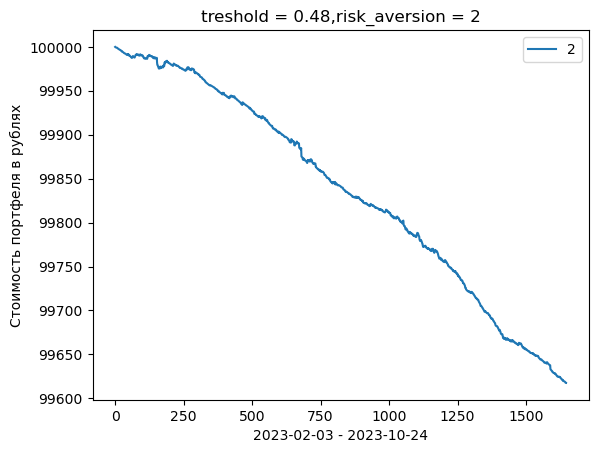

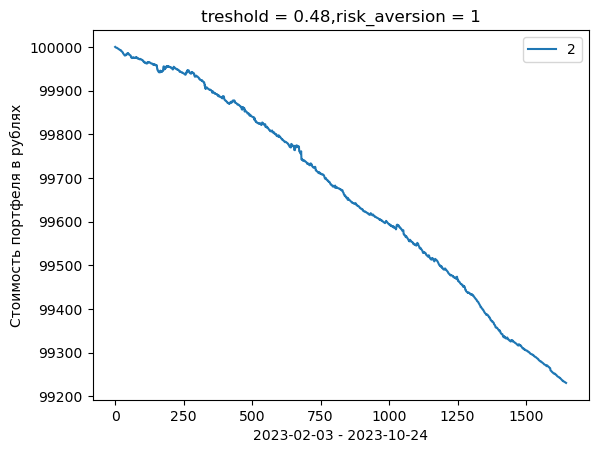

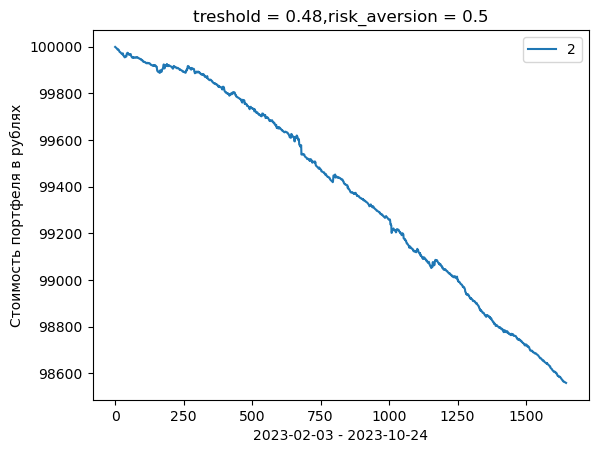

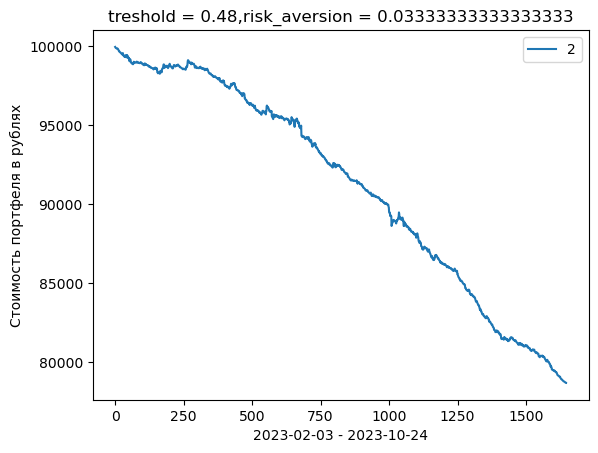

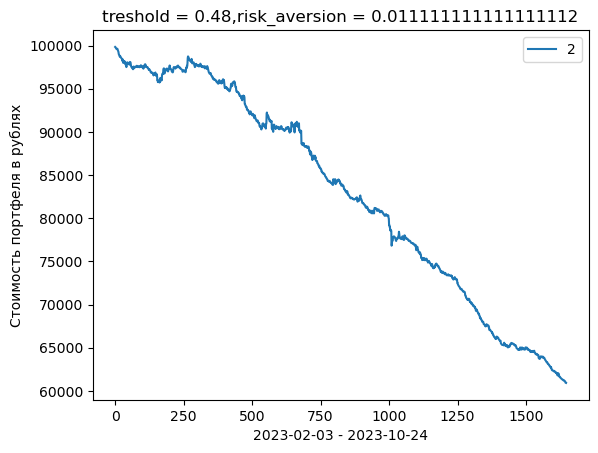

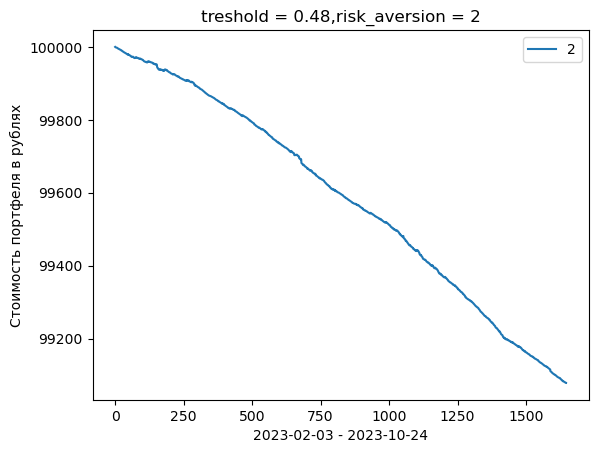

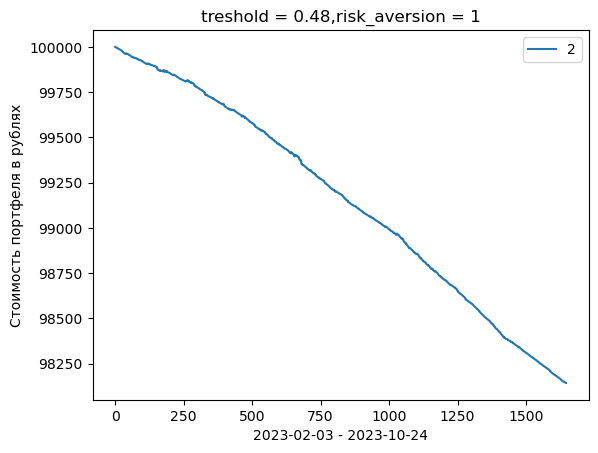

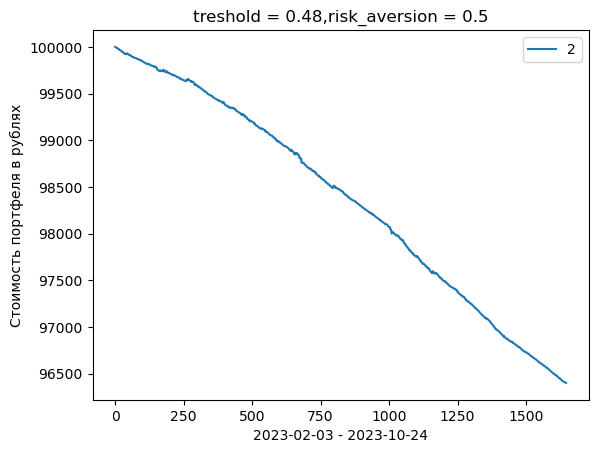

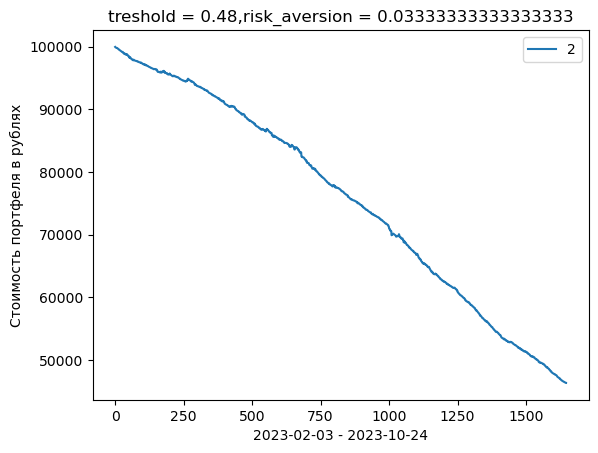

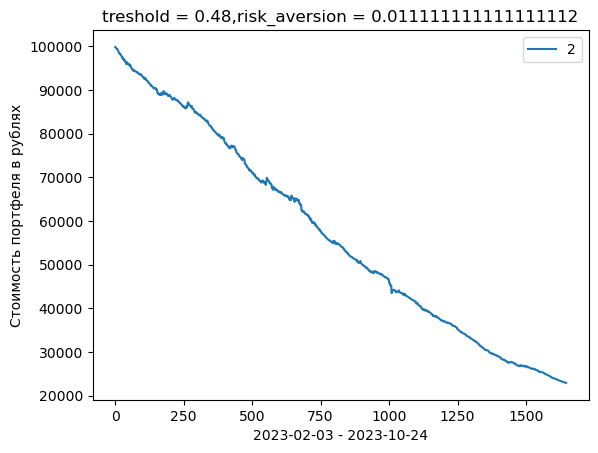

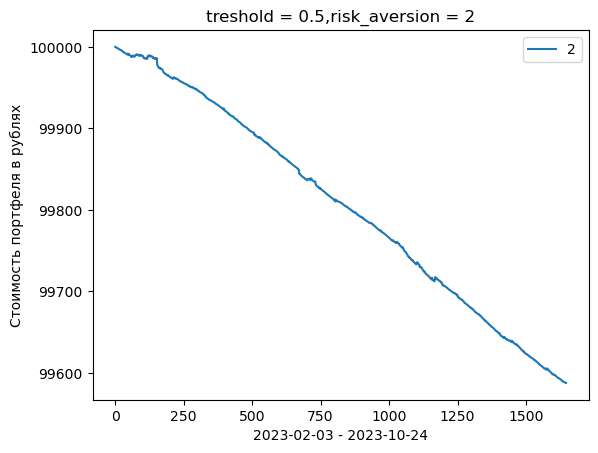

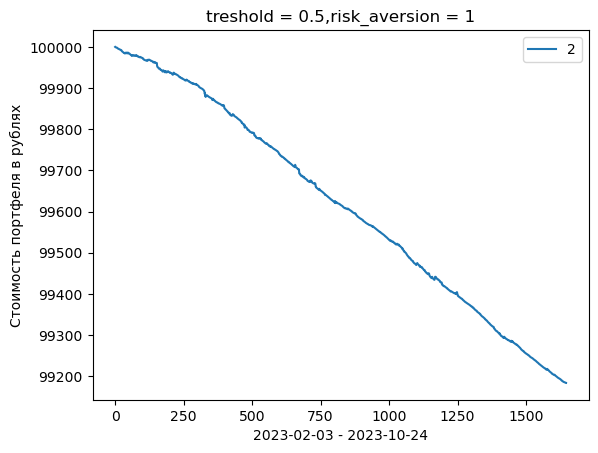

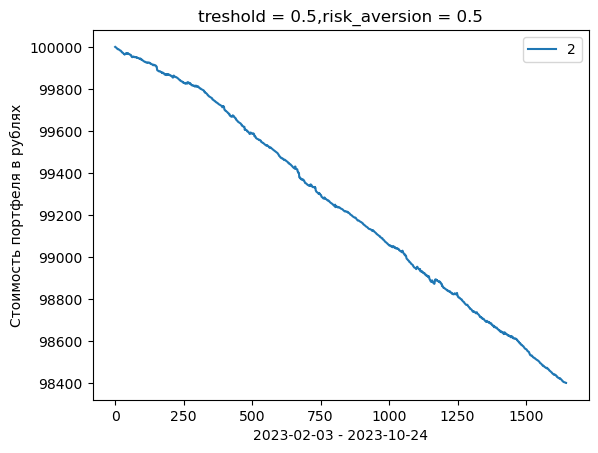

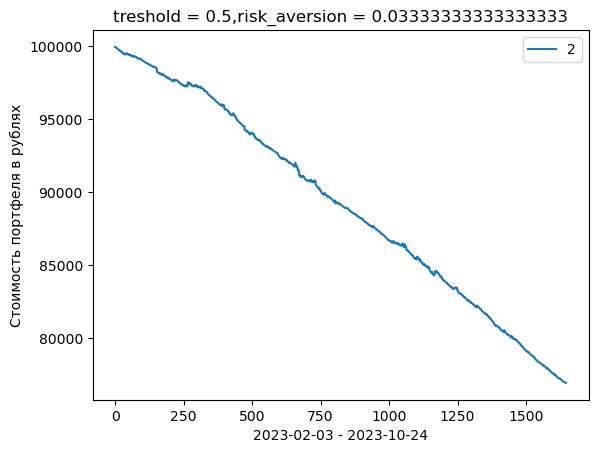

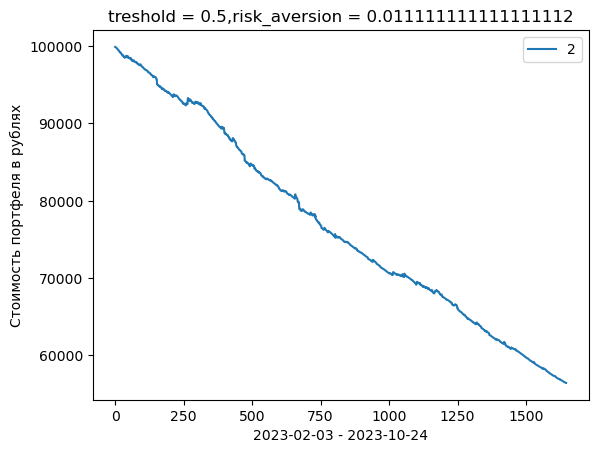

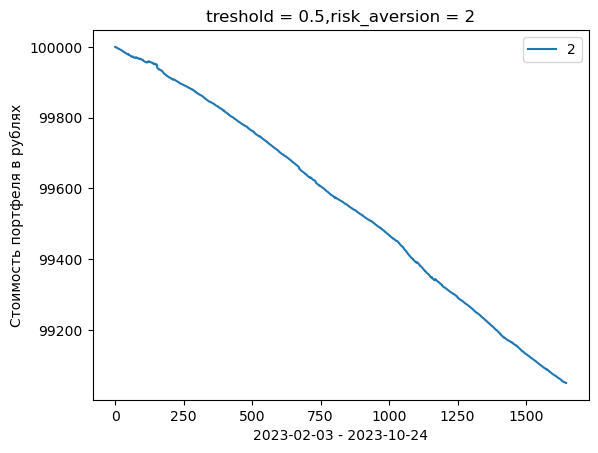

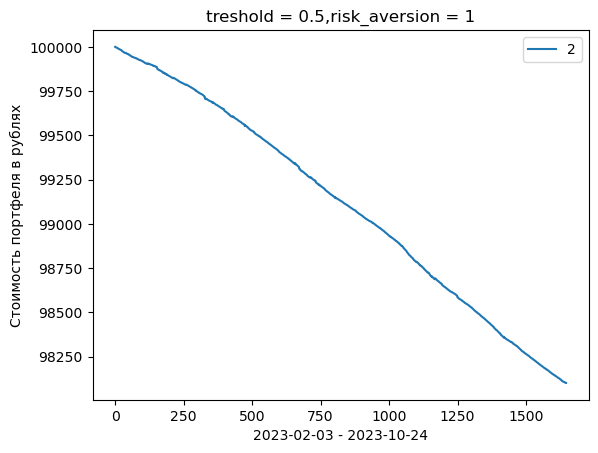

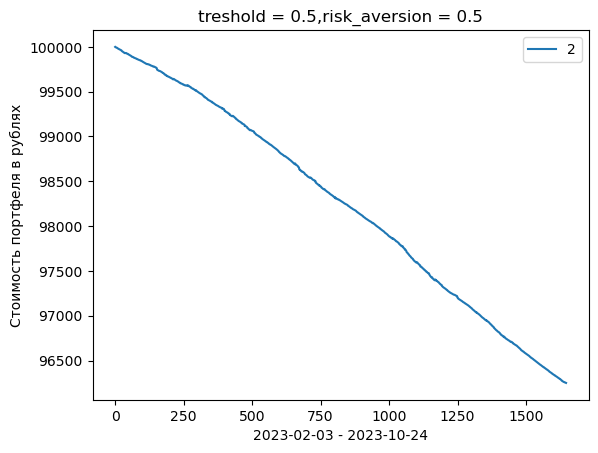

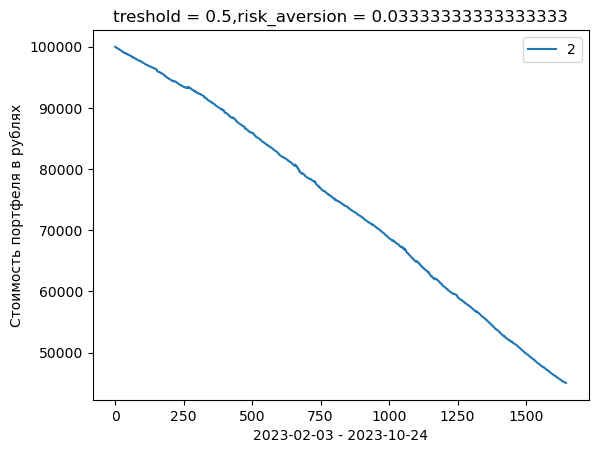

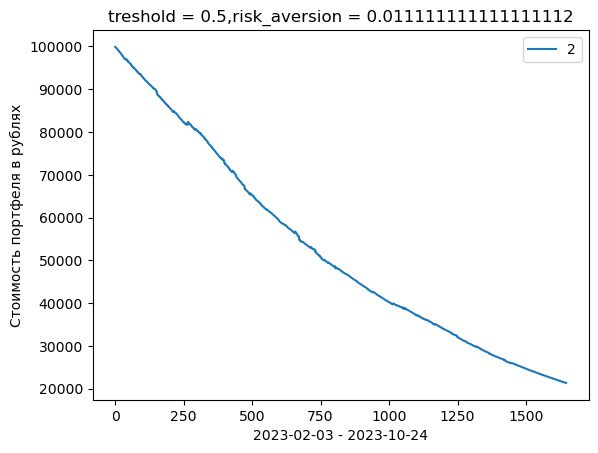

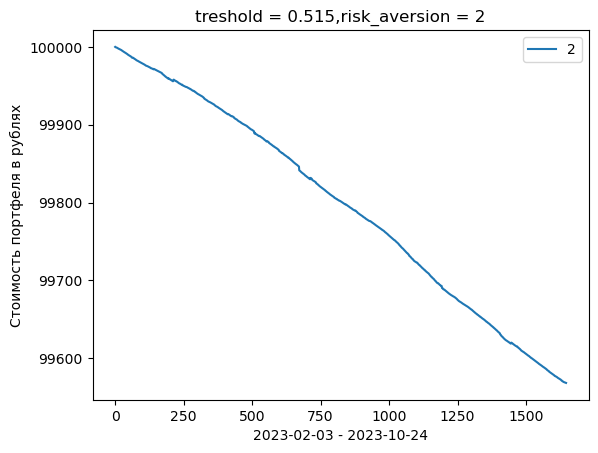

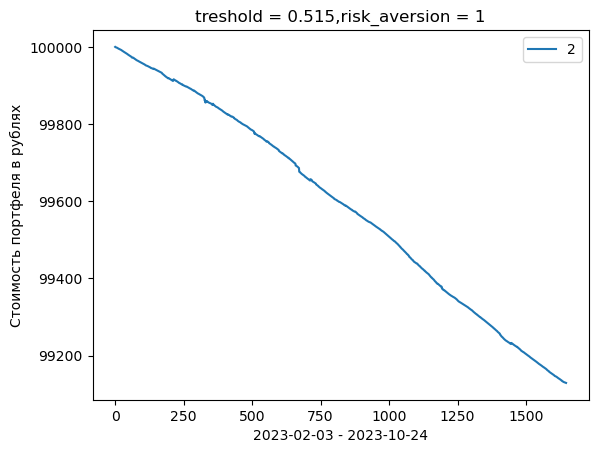

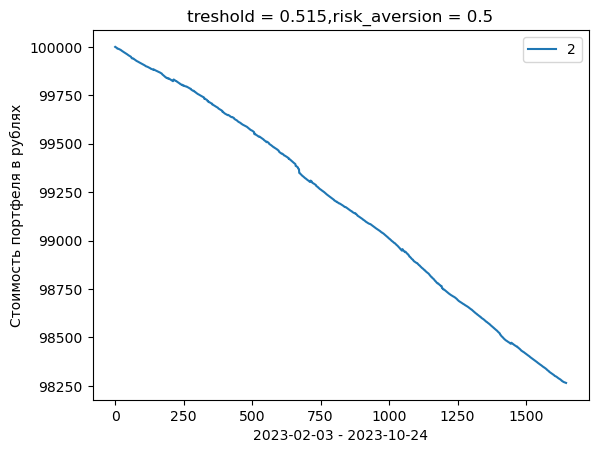

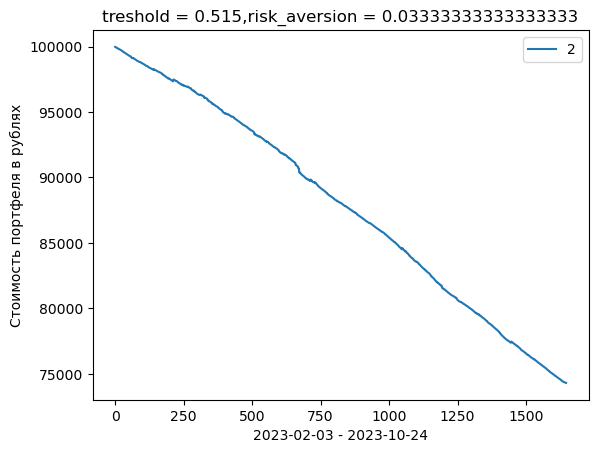

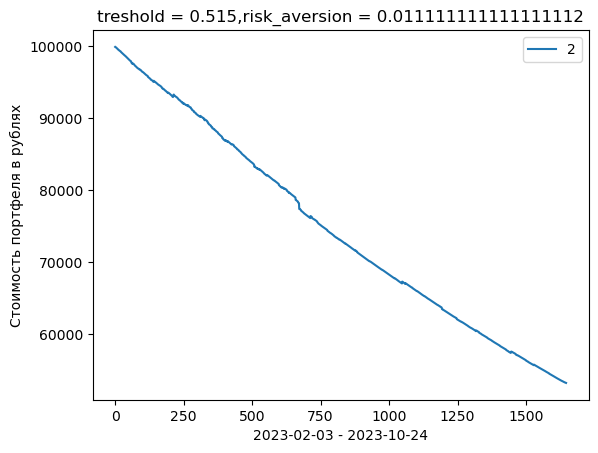

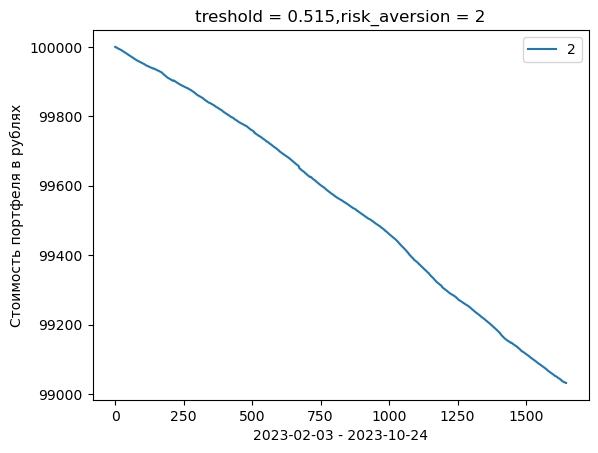

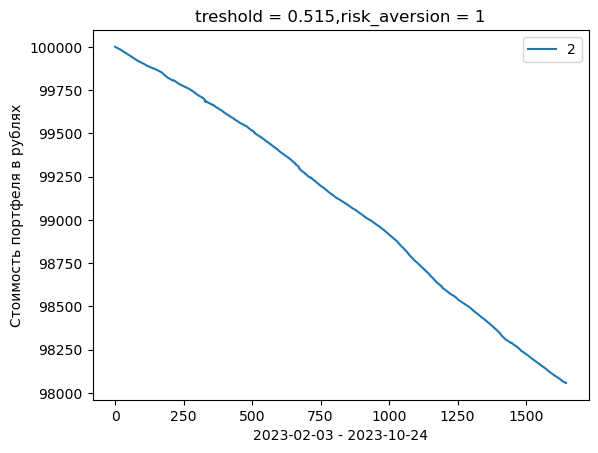

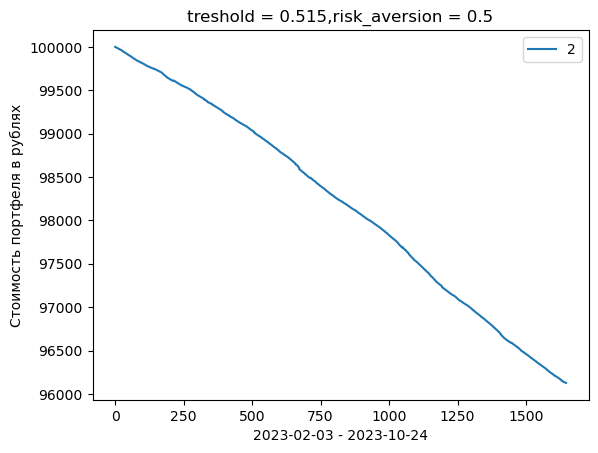

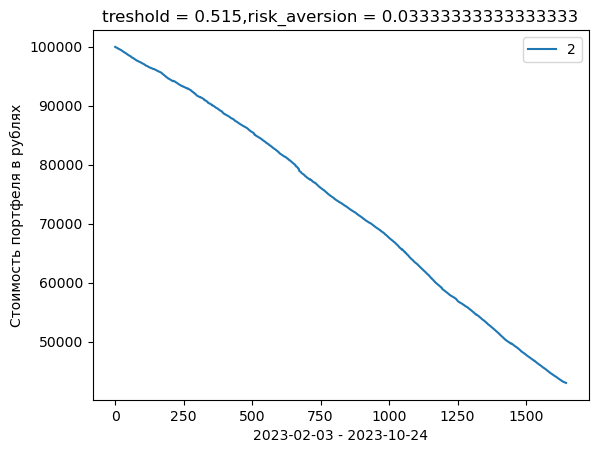

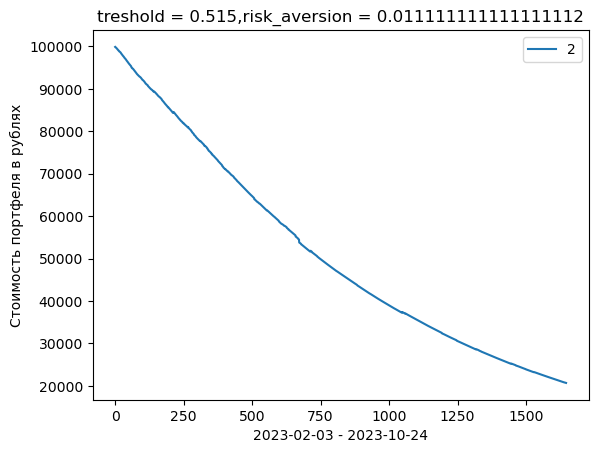

In [39]:
for treshold in [0.48, 0.5, 0.515]:
    for cost in [0.0004, 0.001]:
        for risk_aversion in [2, 1, 1/2, 1/30, 1/90]:
            plt.plot( treshold_dict[treshold][cost][risk_aversion] )
            plt.title(f'treshold = {treshold},risk_aversion = {risk_aversion}')
            plt.xlabel('2023-02-03 - 2023-10-24')
            plt.ylabel('Стоимость портфеля в рублях')
            plt.legend([2, 1, 1/2, 1/30, 1/90])
            plt.show()

# ===Тесты дневного алгоритма===

In [128]:
pred_returns = pd.read_csv('daily_cvxportfolio_pred_returns', index_col='Date')
pred_returns['cash'] = 0

fact_returns = pd.read_csv('daily_cvxportfolio_fact_returns', index_col='Date')
fact_returns['cash'] = 0

#closes = pd.read_csv('cvxportfolio_fact_closes', index_col='Date')

opens = pd.read_csv('daily_cvxportfolio_fact_opens', index_col='Date')
opens['cash'] = 0

# Load
winrate_dict = np.load('daily_winrate_dict.npy',allow_pickle='TRUE').item()

In [129]:
winrate_dict

{'AFKS': 0.5016778523489933,
 'AFLT': 0.5265659955257271,
 'AGRO': 0.5567673378076063,
 'ALRS': 0.49496644295302017,
 'CBOM': 0.38814317673378074,
 'CHMF': 0.6185682326621924,
 'ENPG': 0.4499440715883669,
 'FEES': 0.42170022371364657,
 'FIVE': 0.5467002237136466,
 'FIXP': 0.33165548098434006,
 'GAZP': 0.2483221476510067,
 'GLTR': 0.43512304250559286,
 'GMKN': 0.5850111856823266,
 'HYDR': 0.40492170022371365,
 'IRAO': 0.401565995525727,
 'LKOH': 0.3383668903803132,
 'MAGN': 0.5050335570469799,
 'MGNT': 0.44854586129753915,
 'MOEX': 0.613255033557047,
 'MTSS': 0.5984340044742729,
 'NLMK': 0.5903243847874721,
 'NVTK': 0.54334451901566,
 'OZON': 0.5083892617449665,
 'PHOR': 0.45665548098434006,
 'PIKK': 0.5265659955257271,
 'PLZL': 0.4848993288590604,
 'POLY': 0.5332774049217003,
 'ROSN': 0.5016778523489933,
 'RTKM': 0.35318791946308725,
 'RUAL': 0.5399888143176734,
 'SBER': 0.5050335570469799,
 'SBERP': 0.4681208053691275,
 'SGZH': 0.5480984340044742,
 'SNGS': 0.4767897091722595,
 'SNGSP'

In [62]:
winrate_treshold = 0.45

bad_positions = []
for position, i in enumerate(pred_returns.columns):
    if i != 'cash':
        if winrate_dict[i] < winrate_treshold:
            bad_positions.append(position)
            
bad_positions            

[4, 6, 7, 9, 10, 11, 13, 14, 15, 17, 28]

In [83]:
treshold_dict = {}
for treshold in [0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55]:
    cost_dict = {}
    for cost in [0.0004]:
        risk_dict = {}
        for risk_aversion in [1/160, 1/190, 1/200 ]:
            cost, risk_aversion, nav = backtest(pred_returns = pred_returns,
                 fact_returns = fact_returns,
                 opens = opens,
                 nan_sign = 776655,
                 cash_account = 100000,
                 tol = 1,
                 cost = cost,
                 risk_aversion = risk_aversion,
                 verbose = False)
            risk_dict[risk_aversion] = nav
        cost_dict[cost] = risk_dict
    treshold_dict[treshold] = cost_dict
    print(f'Посчитано для cost={treshold}')    

Посчитано для cost=0.49
Посчитано для cost=0.5
Посчитано для cost=0.51
Посчитано для cost=0.52
Посчитано для cost=0.53
Посчитано для cost=0.54
Посчитано для cost=0.55


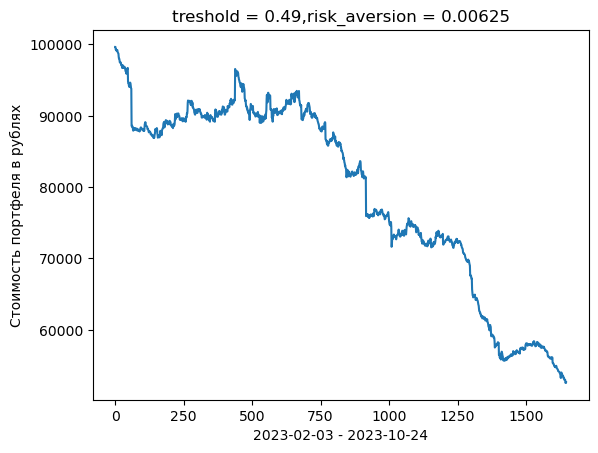

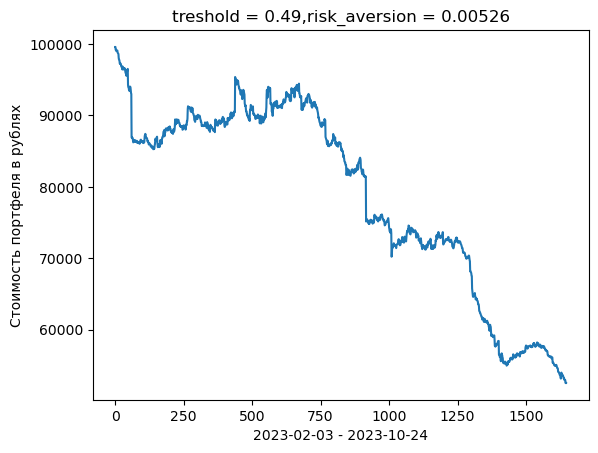

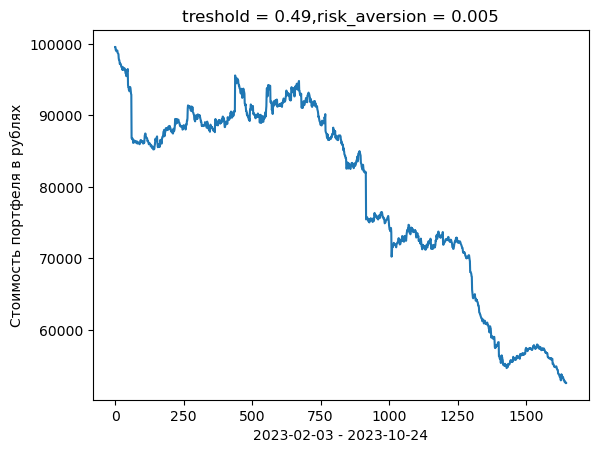

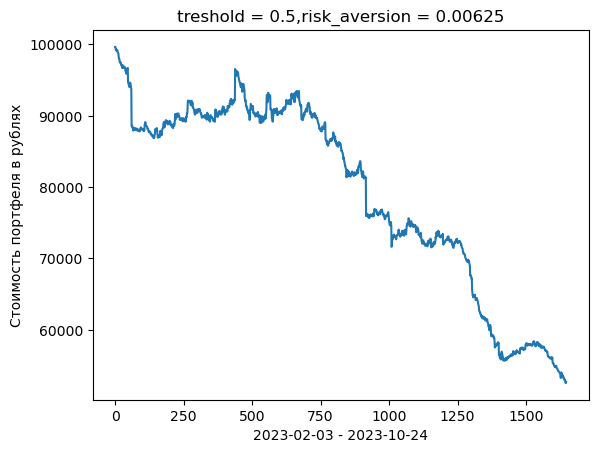

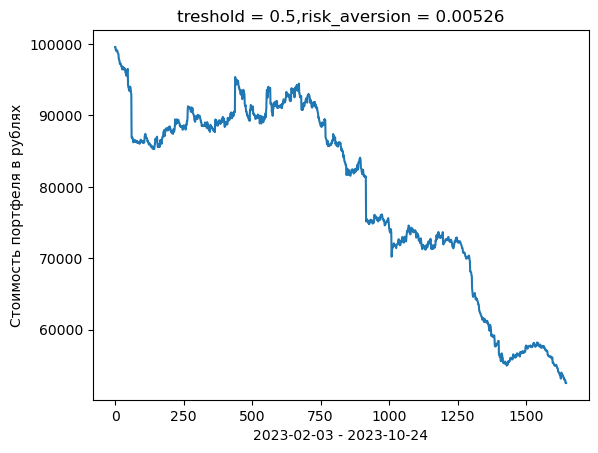

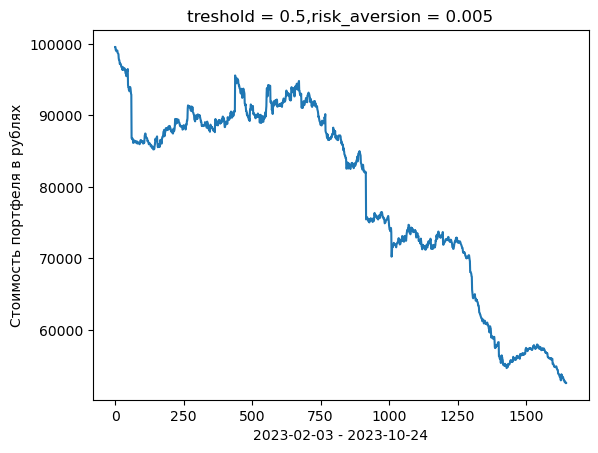

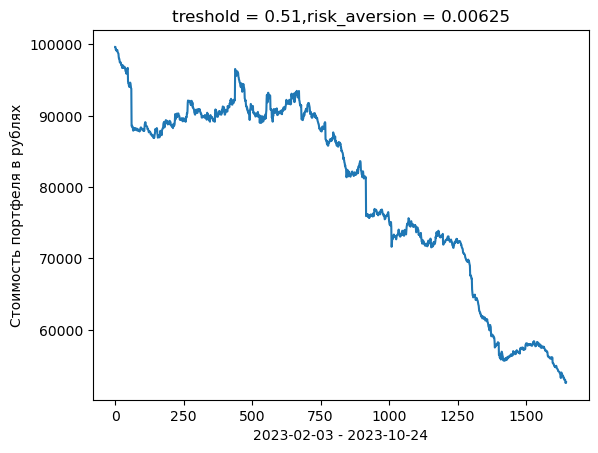

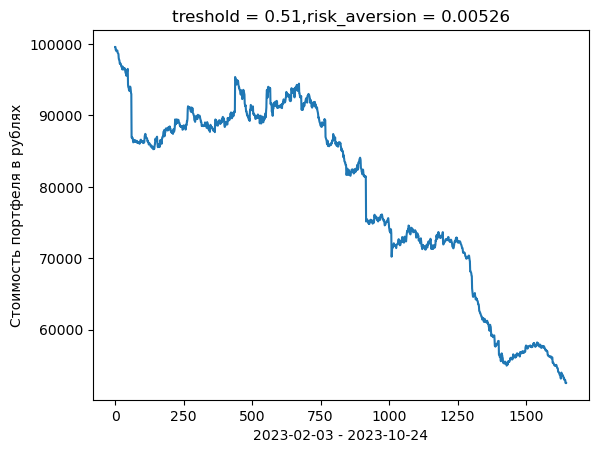

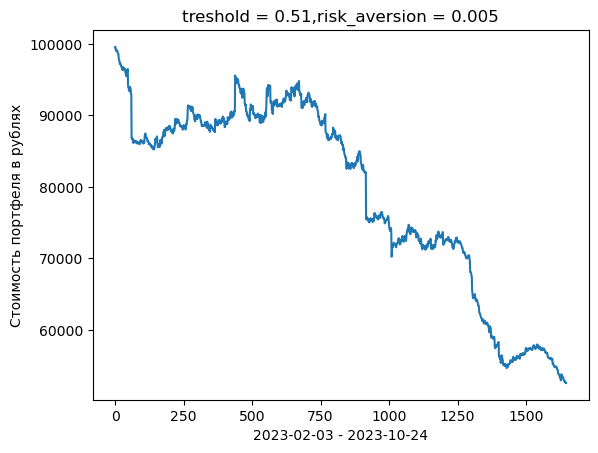

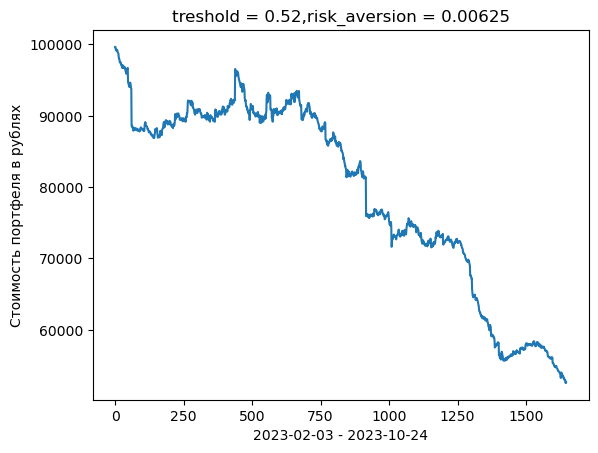

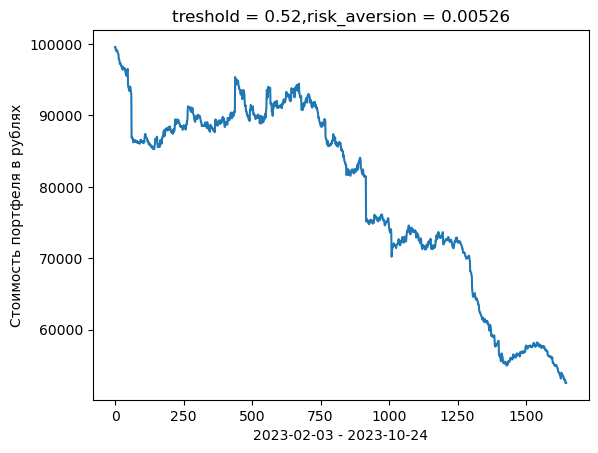

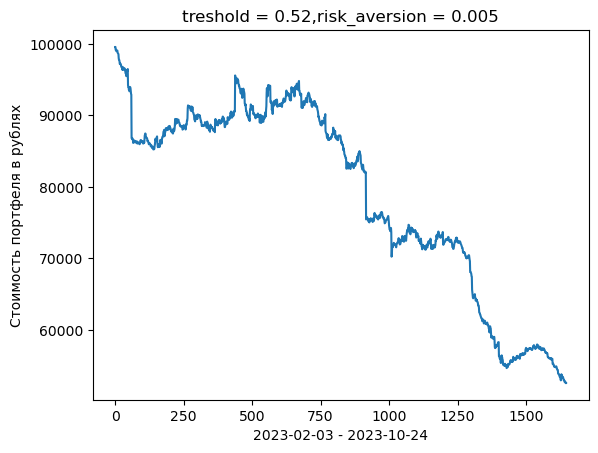

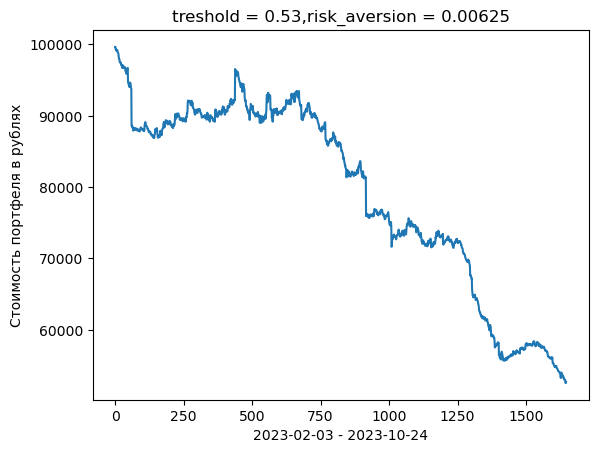

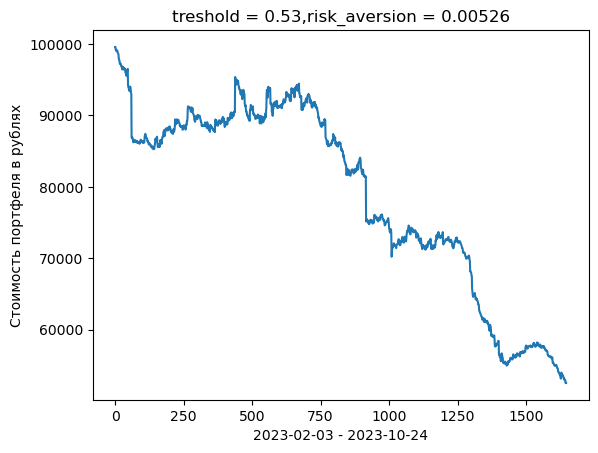

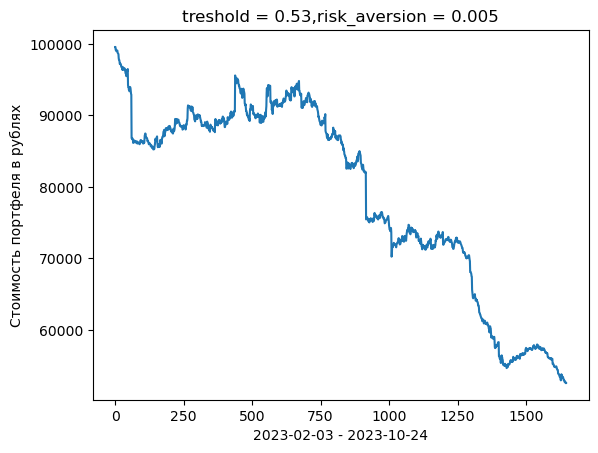

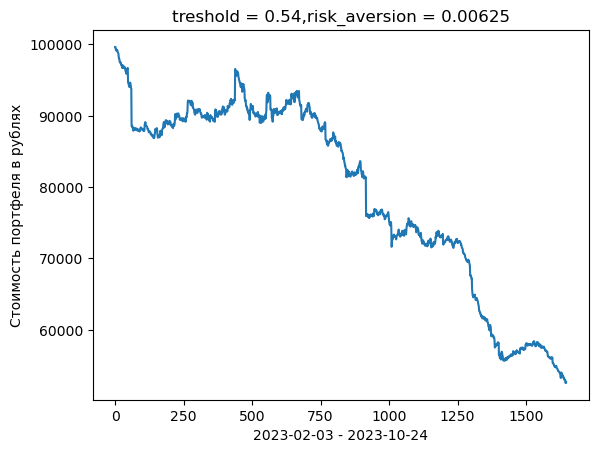

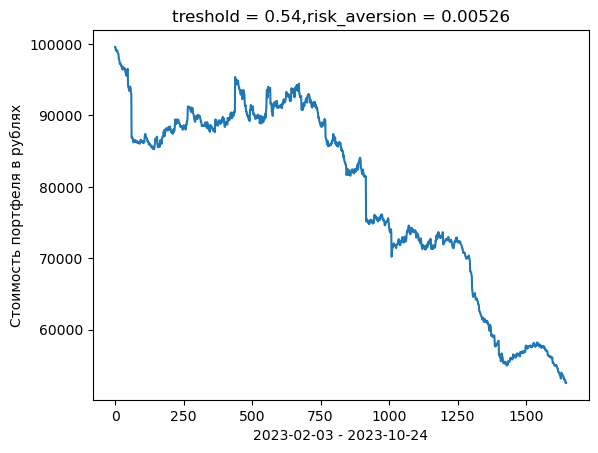

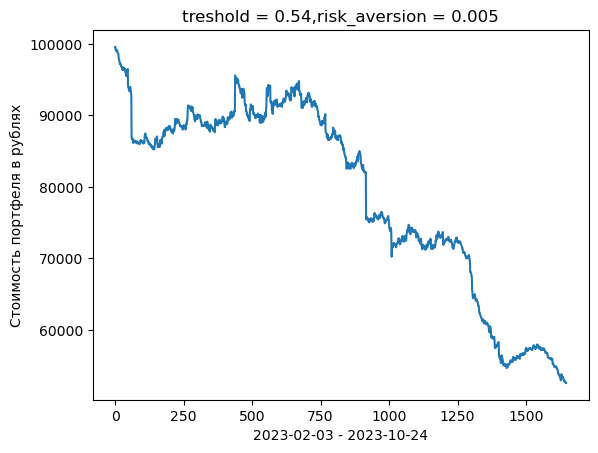

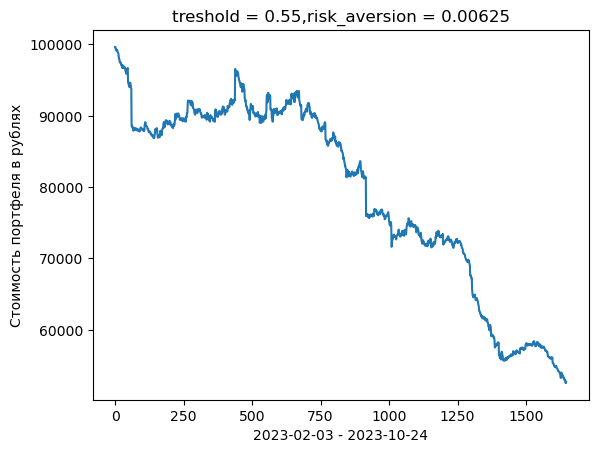

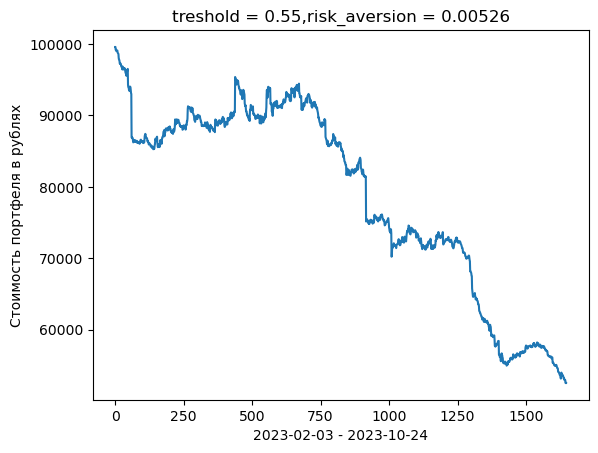

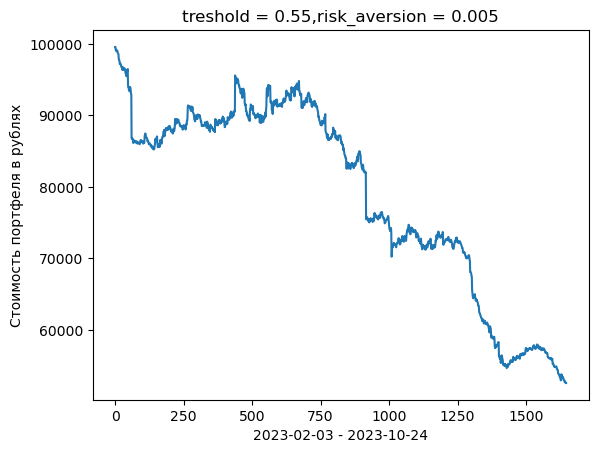

In [119]:
for treshold in [0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55]:
    for cost in [0.0004]:
        for risk_aversion in [1/160, 1/190, 1/200 ]:
            plt.plot( treshold_dict[treshold][cost][risk_aversion] )
            plt.title(f'treshold = {treshold},risk_aversion = {round(risk_aversion,5)}')
            plt.xlabel('2023-02-03 - 2023-10-24')
            plt.ylabel('Стоимость портфеля в рублях')
            plt.show()
            
